# Variational Inference

References:
- https://ermongroup.github.io/cs228-notes/inference/variational/
- https://arxiv.org/abs/1601.00670
- https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf
- Murphy, K. (2012) _Machine Learning: A Probabilistic Perspective_
- [Variational Inference: Simple Example (+ Python Demo)](https://youtu.be/u4BJdBCDR9w?si=Bhlz9HYt1VLXMEY_) video

## Introduction

### Overview
In Bayesian inference problems, we use collected data $\mathbf{z}$ to infer latent variables of interest $\mathbf{x}$ by finding a posterior distribution $p(\mathbf{x} \mid \mathbf{z})$ based on Bayes rule

\begin{align*}
    \overbrace{p(\mathbf{x} \mid \mathbf{z})}^{\text{posterior}} = \frac{\overbrace{p(\mathbf{z} \mid \mathbf{x})}^{\text{likelihood}} \overbrace{p(\mathbf{x})}^{\text{prior}}}{ \underbrace{p(\mathbf{z})}_{\text{evidence}}} = \frac{p(\mathbf{z} \mid \mathbf{x}) p(\mathbf{x})}{\int p(\mathbf{x},\mathbf{z}) d\mathbf{x}}.
\end{align*}

Typically, the normalization constant $p(\mathbf{z})$ is challenging to obtain, because the integral of the joint distribution would be intractable. Depending on the type of inference desired, you may be able to get away with not computing it. _I.e._, if the mode is desired then a maximum _a posteriori_ (MAP) estimate can be found without computing the integral:

\begin{align*}
    \mathbf{\hat{x}_{MAP}} &= \argmax_{\mathbf{x}} p(\mathbf{x} \mid \mathbf{z}) \\
    &= \argmax_{\mathbf{x}} \frac{p(\mathbf{z} \mid \mathbf{x}) p(\mathbf{x})}{\int p(\mathbf{x},\mathbf{z}) d\mathbf{x}} \\
    &= \argmax_{\mathbf{x}} p(\mathbf{z} \mid \mathbf{x}) p(\mathbf{x})
\end{align*}

since the normalization constant doesn't change the value of $\mathbf{\hat{x}_{MAP}}$, only the value of $p(\mathbf{x} \mid \mathbf{z})$. If, however, the full posterior distribution is desired &mdash; an actual probability density function (PDF) &mdash; then we need to resort to variational inference (VI).

In essence, VI **approximates the intractable posterior distribution with a tractable one**. It does so by finding a distribution $q$ among many candidates (function space $Q$) that matches the posterior as close as possible.

This "closeness" metric is provided by the Kullback-Leibler divergence, which measures how different one distribution (candidate distribution $q$) is from another (posterior $p$):
\begin{align*}
    \mathbb{KL}(q(\mathbf{x}) \mid\mid p(\mathbf{x} \mid \mathbf{z})) &\coloneqq \int q(\mathbf{x}) \ln \frac{q(\mathbf{x})}{p(\mathbf{x} \mid \mathbf{z})} d\mathbf{x} \geq 0
\end{align*}
where the divergence value is 0 if $q$ is exactly the same as $p$ and positive otherwise.

It's evident, then, that _VI is just solving the optimization problem with the KL divergence as our cost function_.

\begin{align*}
    q^*(\mathbf{x}) &= \argmin_{q(\mathbf{x}) \in Q} \mathbb{KL}(q(\mathbf{x}) \mid\mid p(\mathbf{x} \mid \mathbf{z})) \\
    &\eqqcolon \argmin_{q(\mathbf{x}) \in Q} \mathcal{L}(q).
\end{align*}

Solving this optimization problem requires the use of variational calculus, since we're optimizing over the function space, _i.e._, finding a function $q$ among all other functions in $Q$ that minimizes the functional $\mathcal{L}$. In most cases, this is a very hard problem to solve, but there are ways around it that we will address in the later sections.

### Evidence Lower Bound (ELBO)
Before we proceed further, we need to consider that the divergence is still intractable, due to the normalization constant $p(\mathbf{z})$ that comes with the posterior $p(\mathbf{x} \mid \mathbf{z})$. To address this, we optimize something called the _Evidence Lower Bound (ELBO)_ instead, which can be extracted by separating the equation into tractable and intractable parts:

\begin{align*}
    \mathbb{KL}(q(\mathbf{x}) \mid\mid p(\mathbf{x} \mid \mathbf{z})) &\coloneqq \int q(\mathbf{x}) \ln \frac{q(\mathbf{x})}{p(\mathbf{x} \mid \mathbf{z})} d\mathbf{x} & & \\
    &= \int q(\mathbf{x}) \ln \frac{q(\mathbf{x}) p(\mathbf{z})}{p(\mathbf{x}, \mathbf{z})} d\mathbf{x} & & \text{(definition of conditional probability)}\\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln \frac{q(\mathbf{x}) p(\mathbf{z})}{p(\mathbf{x}, \mathbf{z})} \bigg] & & \text{(Law of the Unconscious Statistician)} \\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] + \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] & & \\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] + \ln p(\mathbf{z}) - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] & & \text{(argument is independent of $\mathbf{x}$)} \\
    &\geq 0, & & \\
    \therefore \ln p(\mathbf{z}) &\geq \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] \eqqcolon \textrm{ELBO}(q). & &
\end{align*}
We see why it is called ELBO: it serves as a lower bound to the evidence $\ln p(\mathbf{x})$, and if the bound is tight then the proposed candidate distribution is able to fully "explain" the evidence. Because the evidence is based on the data (which is a given in Bayesian inference problems), it's simply an additive constant and has no effect on the optimization:
\begin{align*}
    \argmin_{q(\mathbf{x}) \in Q} \mathbb{KL}(q(\mathbf{x}) \mid\mid p(\mathbf{x} \mid \mathbf{z})) &= \argmin_{q(\mathbf{x}) \in Q} \big\{ \underbrace{\ln p(\mathbf{z})}_{\text{constant}} - \mathrm{ELBO}(q) \big\} \\
    &= \argmax_{q(\mathbf{x}) \in Q} \mathrm{ELBO}(q) \\
    &= \argmax_{q(\mathbf{x}) \in Q} \bigg \{ \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] \bigg \} \\
    &= q^*(\mathbf{x}).
\end{align*}
Hence, by maximizing over the ELBO (which consists of solely tractable parts), we can approximate our candidate distribution as if we were computing the divergence against the actual posterior. Once the candidate distribution $q^*$ is determined to be the closest possible to the posterior, you now have a closed form distribution that can be used for inference, like estimating the mean, variances, etc.

### Alternative to VI
An alternative to the variational inference method is the Markov Chain Monte Carlo (MCMC) method, which is sampling-based. MCMC methods don't provide a distribution; instead they generate samples as if you drew them from the posterior, which you use for inference.

Some pros and cons between VI and MCMC methods:
- _Asymptotic guarantees_ - MCMC is guaranteed to converge to the posterior distribution if given enough time and samples, but not VI. In fact, the VI solution is almost always not going to achieve a global optimum.
- _Scalability_ - VI is easier to scale and parallelize; MCMC is computationally expensive.
- _Complexity_ - MCMC methods are typically easier to implement.
- _Speed_ - VI is usually faster then MCMC.

## Finding a solution

Previously, we mentioned that the (variational) optimization problem is very hard to solve in most cases. We will look at 2 commonly used simplifications applied to make finding a solution possible. The first is to constrain the parametric form of $q$ such that we only optimize over all _possible values of the parameters_, instead of over all possible functions. The second is to make an assumption that the latent variables are independent of each other; this is called the _mean-field approximation_.

### Constraining the parametric form

Instead of optimizing over the function space, we pick a specific function $q$ and instead optimize the parameters of said function. This is the same as a conventional regression problem where we fit data points to a curve: the curve shape (_e.g._, quadratic curve $ax^2 + bx + c$) is chosen and we find values (_e.g._, $a$, $b$, and $c$) that best matches the curve to the data.

#### Example
Consider the latent variable $X$ that follows an exponential distribution which affects the mean of the observed variable $Z$, a normal distributed random variable:
\begin{align*}
    Z \mid X &\sim \mathcal{N}(X, \sigma^2), \\
    X &\sim Exp(\lambda)
\end{align*}
where $\lambda$ and $\sigma^2$ is known to us. **Given some data $Z=z$, we want to approximate the distribution of the mean that generated said data, _i.e._, $p(x \mid z)$.** This is equivalent to the problem of estimating the distribution of the latent variable $X$ based on data collected $Z$.

Fleshing out the posterior equation, we see that the joint distribution is difficult to integrate (hint: the integration of a normal distribution cannot be computed analytically to begin with):
\begin{align*}
    p(x \mid z) &= \frac{p(z \mid x) p(x)}{p(z)} \\
    &= \frac{p(z \mid x) p(x)}{\int p(x, z) dx} \\
    &= \frac{ \sqrt{2 \pi \sigma^2}^{-1} e^{-(z - x)^2 / (2 \sigma^2)} \lambda e^{-\lambda x} }{\int \sqrt{2 \pi \sigma^2}^{-1} e^{-(z - x)^2 / (2 \sigma^2)} \lambda e^{-\lambda x} dx}.
\end{align*}

To this end, we shall go with the **exponential distribution family $Exp(\mathbf{x}; \theta)$** as our candidate. _(In this simplification method, the decision on what distribution family to use is up to the designer, usually motivated by domain knowledge.)_ First, we evaluate the ELBO
\begin{align*}
    \mathrm{ELBO}(q) &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] & & \\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln \bigg\{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-(z - x)^2 / (2 \sigma^2)} \cdot \lambda e^{-\lambda x} \bigg\} \bigg] - \mathbb{E}_{q(\mathbf{x})} \big[ \ln \big\{ \theta e^{-\theta x}  \big\} \big] & & \\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln \bigg\{ \frac{\lambda}{\sqrt{2 \pi \sigma^2}} e^{-(z - x)^2 / (2 \sigma^2) -\lambda x} \bigg\} \bigg] - \mathbb{E}_{q(\mathbf{x})} \big[ \ln \big\{ \theta e^{-\theta x}  \big\} \big] & & \\
    &= \mathbb{E}_{q(\mathbf{x})} \bigg[\ln \bigg\{ \frac{\lambda}{\sqrt{2 \pi \sigma^2}} \bigg\} -\frac{(z - x)^2}{2 \sigma^2} -\lambda x \bigg] - \mathbb{E}_{q(\mathbf{x})} \big[ \ln \theta -\theta x \big] & & \\
    &= \ln \bigg\{ \frac{\lambda}{\sqrt{2 \pi \sigma^2}} \bigg\} + \mathbb{E}_{q(\mathbf{x})} \bigg[-\frac{(z - x)^2}{2 \sigma^2} - \lambda x \bigg] - \ln \theta + \mathbb{E}_{q(\mathbf{x})} \big[ \theta x \big] & & \\
    &= C - \ln \theta + \mathbb{E}_{q(\mathbf{x})} \bigg[-\frac{(z - x)^2}{2 \sigma^2} - \lambda x \bigg] + \mathbb{E}_{q(\mathbf{x})} \big[ \theta x \big] & & \text{($C = \ln \big\{ \lambda / \sqrt{2 \pi \sigma^2} \big\}$)} \\
    &= C - \ln \theta + \mathbb{E}_{q(\mathbf{x})} \bigg[-\frac{1}{2 \sigma^2} (z^2 - 2xz + x^2) - \lambda x \bigg] + \mathbb{E}_{q(\mathbf{x})} \big[ \theta x \big] & & \\
    &= C - \ln \theta + \mathbb{E}_{q(\mathbf{x})} \bigg[-\frac{z^2}{2 \sigma^2} + \frac{z}{\sigma^2}x -\frac{1}{2 \sigma^2}x^2 + (\theta - \lambda) x \bigg] & & \\
    &= C - \ln \theta -\frac{z^2}{2 \sigma^2} + \frac{z}{\sigma^2} \bigg( \frac{1}{\theta} \bigg) - \frac{1}{2 \sigma^2} \bigg( \frac{2}{\theta^2} \bigg) + (\theta - \lambda) \bigg( \frac{1}{\theta} \bigg) & & \text{($Y \sim Exp(\beta) \Rightarrow \mathbb{E}[Y] = 1/\beta$, $\mathbb{E}[Y^2] = 2/\beta^2$)} & & \\
    &= C - \ln \theta -\frac{z^2}{2 \sigma^2} + 1 + \bigg( \frac{z}{\sigma^2} - \lambda  \bigg) \bigg( \frac{1}{\theta} \bigg) - \frac{1}{\sigma^2} \bigg( \frac{1}{\theta^2} \bigg) & & \\
    &= C^\prime - \ln \theta + \bigg( \frac{z}{\sigma^2} - \lambda  \bigg) \bigg( \frac{1}{\theta} \bigg) - \frac{1}{\sigma^2} \bigg( \frac{1}{\theta^2} \bigg) & & \text{($C^\prime = C + z^2/(2 \sigma^2) + 1$)}\\
    &= \mathcal{L}(\theta)
\end{align*}
and see that it's a function that depends on the hyperparameter $\theta$.

Next, to solve the optimization problem, we find the maximum of the ELBO by taking the first derivative and setting it to zero. _Note: while we are able to find analytical derivatives for this ELBO, in many cases numerical integration may still be required._
\begin{align*}
    \frac{\partial \mathcal{L}(\theta)}{\partial \theta} &= \frac{\partial}{\partial \theta} \bigg[ C^\prime - \ln \theta + \bigg( \frac{z}{\sigma^2} - \lambda  \bigg) \bigg( \frac{1}{\theta} \bigg) - \frac{1}{\sigma^2} \bigg( \frac{1}{\theta^2} \bigg) \bigg] \\
    &= 0 - \frac{1}{\theta} - \bigg( \frac{z}{\sigma^2} - \lambda \bigg) \frac{1}{\theta^2} + \frac{2}{\sigma^2} \bigg( \frac{1}{\theta^3} \bigg) \\
    &\coloneqq 0, \\
    \therefore \theta^2 + \bigg( \frac{z}{\sigma^2} - \lambda \bigg) \theta - \frac{2}{\sigma^2} = 0 &\Rightarrow \theta = \frac{1}{2} \bigg[ -\bigg( \frac{z}{\sigma^2} - \lambda \bigg) \pm \sqrt{ \bigg( \frac{z}{\sigma^2} - \lambda \bigg)^2 + 4 \bigg(\frac{2}{\sigma^2} \bigg) } \bigg]
\end{align*}
where the implication is made using the quadratic formula. Since our proposed distribution is of the exponential family, which imposes a restriction on the parameter $\theta > 0$, we can further simplify the last equation. Note that, because
\begin{align*}
    -\bigg( \frac{z}{\sigma^2} - \lambda \bigg) < \sqrt{ \bigg( \frac{z}{\sigma^2} - \lambda \bigg)^2 + 4 \bigg(\frac{2}{\sigma^2} \bigg) }
\end{align*}
the only solution that yields admissable values is the one that adds the second term 
\begin{align*}
    \theta = \frac{1}{2} \bigg[ -\bigg( \frac{z}{\sigma^2} - \lambda \bigg) + \sqrt{ \bigg( \frac{z}{\sigma^2} - \lambda \bigg)^2 + 4 \bigg(\frac{2}{\sigma^2} \bigg) } \bigg] > 0.
\end{align*}

Let's proceed by setting $\lambda = 1$, $\sigma^2 = 1$ and say that we obtain a single data point $z = 1.3$. We see then our analytically computed $\theta$ is
\begin{align*}
    \theta &= \frac{1}{2} \bigg[ -\bigg( \frac{1.3}{1} - 1 \bigg) + \sqrt{ \bigg( \frac{1.3}{1} - 1 \bigg)^2 + 4 \bigg(\frac{2}{1} \bigg) } \bigg] \\
    &= \frac{1}{2} ( -0.3 + \sqrt{ 8.09 } ) \\
    &= 1.2721.
\end{align*}

We can compare this value with one that we obtain by actually optimizing the ELBO &mdash; which is the way to go in most cases when an analytical gradient cannot be found.

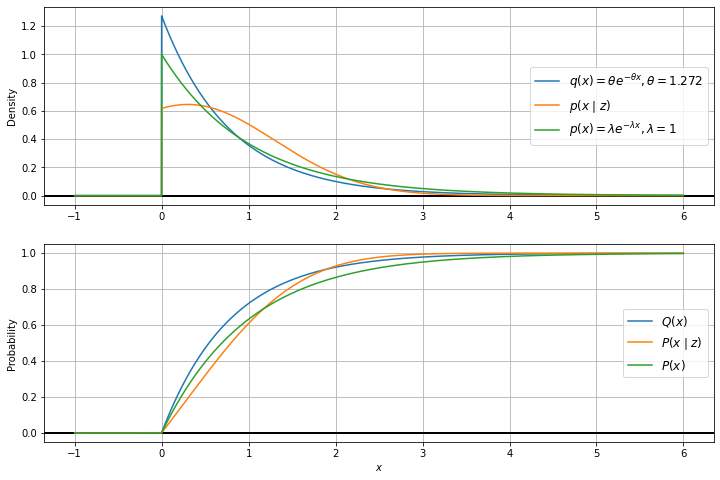

In [116]:
from scipy.optimize import minimize
from scipy.stats import expon, norm, rv_continuous
from scipy.integrate import trapezoid
import numpy as np
import matplotlib.pyplot as plt

# Define pre-determined/given values
data = 1.3
norm_var = 1
exp_rate = 1
x0 = [0.5] # starting value
support_step_size = 1e-3

# Define the ELBO as the cost function
def ELBO(theta, z, var_sigma, lamb):
    return -np.log(theta) + (z/var_sigma - lamb) * 1/theta - 1/var_sigma * 1/np.square(theta) # ignoring the constant

# Define the joint probability distribution
class JointDistribution(rv_continuous):
    def _pdf(self, x):
        return expon.pdf(x, scale=1/exp_rate) * norm.pdf(x, loc=data, scale=np.sqrt(norm_var))

joint_dist = JointDistribution(a=0, b=np.inf, name="joint_dist") # unnormalized

# Define bounds for the optimization problem
bnds = [(1e-9, None)]

# Minimize the negative ELBO
res = minimize(lambda theta: -ELBO(theta, data, norm_var, exp_rate), x0, method="SLSQP", bounds=bnds)

# Plot the comparison of the PDFs
support = np.arange(-1, 6, support_step_size)
q = expon.pdf(support, scale=1/res.x[0])
p = joint_dist.pdf(support)
g = expon.pdf(support, scale=1/exp_rate) # the actual distribution of X
norm_const = trapezoid(p, support) # compute the (approx) normalization constant for the joint PDF

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.set_facecolor("white")
ax[0].axhline(0, color='black', linewidth=2)
ax[0].plot(support, q, label=r"$q(x) = \theta e^{{-\theta x}}, \theta={}$".format(np.round(res.x[0], 3)))
ax[0].plot(support, p/norm_const, label="$p(x \mid z)$")
ax[0].plot(support, g, label=r"$p(x) = \lambda e^{{-\lambda x}}, \lambda={}$".format(exp_rate))
ax[0].grid()
ax[0].legend(loc="right", fontsize="large")
ax[0].set_ylabel("Density")

# Plot the comparison of the CDFs
Q = expon.cdf(support, scale=1/res.x[0])
P = np.cumsum(p) * support_step_size / norm_const
G = expon.cdf(support, scale=1/exp_rate)
ax[1].axhline(0, color='black', linewidth=2)
ax[1].plot(support, Q, label="$Q(x)$")
ax[1].plot(support, P, label="$P(x \mid z)$")
ax[1].plot(support, G, label="$P(x)$")
ax[1].grid()
ax[1].legend(loc="right", fontsize="large")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("Probability")

plt.show()

We get the same result for $\theta = 1.272$ and that gives us the exponential distribution that approximates our posterior shown above. Notice that our approximated distribution $q(x)$ is quite close to the latent variable $X \sim Exp(\lambda)$ that we intended to estimate based on collected data $Z$.

Therefore, using data collection and VI, we find the $Exp(\theta)$ distribution that can be used to perform inference on the latent variable $X$.

### Mean-field approximation
In contrast to the previous method, the mean-field method places a different constraint on the distribution of $q$; instead of picking a parametric form, we assume that the latent variables are independent, that is, the variational family _factorizes_:
\begin{align*}
    q(\mathbf{x}) &= q(x_1, x_2, \ldots, x_n) = \prod_{i=1}^m q_i(\mathbf{x_i}).
\end{align*}
This is called the _mean-field approximation_. _(The mean-field name has origins in statistical physics; it comes from the fact that the neighboring effects on a body are replaced by their mean effect, which will become clear when you see the resulting $q$.)_ Notice that the factorization of $q(\mathbf{x})$ **does not** mean that the arguments $\mathbf{x_i}$ to the decomposed distributions $q_i$ are necessarily scalar. _I.e._, there are $n$ latent variables with $m$ distributions where $n$ is not necessarily equal to $m$.

This retains the need to optimize over the function space $Q$, but as we shall see, the form of each $q_i(\mathbf{x_i})$ emerges through some simple algebraic manipulation and evaluating the functional derivative.

#### Form of $q_j(\mathbf{x_j})$
Recall that the VI problem is to minimize the KL divergence and thus to maximize the ELBO:
\begin{align*}
    q^*(\mathbf{x}) &= \argmax_q \mathrm{ELBO}(q)\\
    &= \argmax_q \bigg \{ \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x})\bigg] \bigg \}.
\end{align*}

By applying the mean-field assumption to the ELBO, we can obtain an expression for the $j$-th distribution as (see the Appendix for the full derivation)
\begin{align*}
    q_j(\mathbf{x_j}) \propto \exp \bigg \{ \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] \bigg \}.
\end{align*}

## Appendix: Derivation of $q_j(x_j)$

The following statements are true if $X_1$ and $X_2$ are independent but their relationship with $Z$ is unknown (could be dependent).
\begin{align*}
    p(x_1, x_2) &= p(x_1) p(x_2), \\
    p(x_1 \mid x_2) = p(x_1), &\qquad p(x_2 \mid x_1) = p(x_2), \\
    p(x_1 \mid x_2, z) = p(x_1 \mid z), &\qquad p(x_2 \mid x_1, z) = p(x_2 \mid z).
\end{align*}

Then, we use the definition of conditional probability recursively to factorize the joint probability $p(x_1, \ldots, x_j, \ldots, x_m, z)$:
\begin{align*}
    p(x_1, \ldots, x_j, \ldots, x_m, z) &= p(x_1 \mid x_2, \ldots, x_m, z) p(x_2, \ldots, x_m, z) \\
    &= p(x_1 \mid x_2, \ldots, x_m, z) p(x_2 \mid x_3, \ldots, x_m, z) p(x_3, \ldots, x_m, z) \\
    &\qquad \vdots \\
    &= p(x_1 \mid x_2, \ldots, x_m, z) p(x_2 \mid x_3, \ldots, x_m, z) \ldots p(x_j \mid x_{j+1}, \ldots, x_m, z) \ldots p(x_m \mid z) p(z) \\
    \text{($X_i$ are mutually independent)} \qquad &= p(x_1 \mid z) p(x_2 \mid z) \ldots p(x_j \mid z) \ldots p(x_m \mid z) p(z).
\end{align*}

Recall that the ELBO is
\begin{align*}
    \mathrm{ELBO}(q) &= \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \mathbb{E}_{q(\mathbf{x})} \bigg[ \ln q(\mathbf{x}) \bigg] \\
    \text{(Law of the Unconscious Statistician)} \qquad &= \int_{\mathbf{x}} q(\mathbf{x}) \ln p(\mathbf{x}, \mathbf{z}) d\mathbf{x} - \int_{\mathbf{x}} q(\mathbf{x}) \ln q(\mathbf{x}) d\mathbf{x} \\
    \text{(Mean-field approximation)} \qquad &= \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i=1}^m q_i(\mathbf{x_i}) \ln p(\mathbf{x}, \mathbf{z}) \bigg) d\mathbf{x_1} \ldots d\mathbf{x_m} -\\ & \quad \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i=1}^m q_i(\mathbf{x_i}) \ln \prod_{i=1}^m q_i(\mathbf{x_i}) \bigg) d\mathbf{x_1} \ldots d\mathbf{x_m}.
\end{align*}

### First term of the ELBO
For the first integral term, we begin by noting that the joint probability can be factorized into
\begin{align*}
    \ln p(\mathbf{x}, \mathbf{z}) &= \ln \big\{ p(\mathbf{x_1} \mid \mathbf{z}) \ldots p(\mathbf{x_j} \mid \mathbf{z}) \ldots p(\mathbf{x_m} \mid \mathbf{z}) p(\mathbf{z}) \big\} \\
    &= \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \ldots p_{\mathbf{x_j} \mid \mathbf{z}} \ldots p_{\mathbf{x_m} \mid \mathbf{z}} p_{\mathbf{z}} \big\}
\end{align*}
where a simplified notation is adopted in the last line. This leads to the decoupling of integrals in the first term
\begin{align*}
    \int_{\mathbf{x}} q(\mathbf{x}) \ln p(\mathbf{x}, \mathbf{z}) d\mathbf{x} &= \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \ldots p_{\mathbf{x_j} \mid \mathbf{z}} \ldots p_{\mathbf{x_m} \mid \mathbf{z}} p_{\mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} \\
    &= \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} + \ldots \\
    &\quad \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_j} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} + \dots \\
    &\quad \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_m} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} + \\
    &\quad \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1}
\end{align*}
which means that we can move the integration order around since the integrand is a separable function. Specifically, we move the $\mathbf{x_j}$ integral and the corresponding distribution $q_j$ out, then (re-)combine the sum:
\begin{align*}
    \int_{\mathbf{x}} q(\mathbf{x}) \ln p(\mathbf{x}, \mathbf{z}) d\mathbf{x} &= \int_{\mathbf{x_j}} \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \ldots \\
    &\quad \int_{\mathbf{x_j}} \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_j} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \dots \\
    &\quad \int_{\mathbf{x_j}} \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{x_m} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \\
    &\quad \int_{\mathbf{x_j}} \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i=1}^m q_i \ln \big\{ p_{\mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \ldots \\
    &\quad \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{x_j} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \dots \\
    &\quad \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{x_m} \mid \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \\
    &\quad \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{x_1} \mid \mathbf{z}} \ldots p_{\mathbf{x_j} \mid \mathbf{z}} \ldots p_{\mathbf{x_m} \mid \mathbf{z}} p_{\mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i \ln \big\{ p_{\mathbf{x}, \mathbf{z}} \big\} d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j}.
\end{align*}
We see that this is simply a nested expectation of the log joint probability, first over the variables that aren't $\mathbf{x_j}$ and then over $\mathbf{x_j}$.
\begin{align*}
    \int_{\mathbf{x}} q(\mathbf{x}) \ln p(\mathbf{x}, \mathbf{z}) d\mathbf{x} &= \int_{\mathbf{x_j}} q_j(\mathbf{x_j}) \bigg( \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \prod_{i \neq j}^m q_i(\mathbf{x_i}) \ln p(\mathbf{x}, \mathbf{z}) d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} \bigg) d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} q_j(\mathbf{x_j}) \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] d\mathbf{x_j} \\
    &= \mathbb{E}_{q_j(\mathbf{x_j})} \bigg[ \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] \bigg].
\end{align*}

### Second term of the ELBO

The second integral follows a similar procedure.

\begin{align*}
    \int_{\mathbf{x}} q(\mathbf{x}) \ln q(\mathbf{x}) d\mathbf{x} &= \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i=1}^m q_i \sum_{i=1}^m \ln q_i \bigg) d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} \\
    &= \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i=1}^m q_i \ln q_j \bigg) d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} + \\
    &\quad \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_j}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i=1}^m q_i ( \ln q_1 + \ldots + \ln q_{j-1} + \ln q_{j+1} + \ldots + \ln q_m) \bigg) d\mathbf{x_m} \ldots d\mathbf{x_j} \ldots d\mathbf{x_1} \\
    &= \int_{\mathbf{x_j}} q_j \ln q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i \neq j}^m q_i\bigg) d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} + \\
    &\quad \int_{\mathbf{x_j}} q_j \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i \neq j}^m q_i \sum_{i \neq j}^m \ln q_i \bigg) d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} q_j \ln q_j \bigg( \int_{\mathbf{x_1}} q_1 d\mathbf{x_1} \ldots \int_{\mathbf{x_{j-1}}} q_{j-1} d\mathbf{x_{j-1}} \int_{\mathbf{x_{j+1}}} q_{j+1} d\mathbf{x_{j+1}} \ldots \int_{\mathbf{x_m}} q_m d\mathbf{x_m} \bigg) d\mathbf{x_j} + \\
    &\quad \int_{\mathbf{x_j}} q_j  d\mathbf{x_j} \bigg( \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i \neq j}^m q_i \sum_{i \neq j}^m \ln q_i \bigg) d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} \bigg) \\
    \text{($\int_{\mathbf{x_i}} q_i d\mathbf{x_i} = 1$)} \qquad &= \int_{\mathbf{x_j}} q_j \ln q_j d\mathbf{x_j} + \int_{\mathbf{x_1}} \ldots \int_{\mathbf{x_{j-1}}} \int_{\mathbf{x_{j+1}}} \ldots \int_{\mathbf{x_m}} \bigg( \prod_{i \neq j}^m q_i \sum_{i \neq j}^m \ln q_i \bigg) d\mathbf{x_m} \ldots d\mathbf{x_{j+1}} d\mathbf{x_{j-1}} \ldots d\mathbf{x_1} \\
    &= \int_{\mathbf{x_j}} q_j(\mathbf{x_j}) \ln q_{j}(\mathbf{x_j}) d\mathbf{x_j} + \int_{\mathbf{x_{-j}}} q_{-j}(\mathbf{x_{-j}}) \ln q_{-j}(\mathbf{x_{-j}}) d\mathbf{x_{-j}} \\
    &= \mathbb{E}_{q_{j}(\mathbf{x_j})} \bigg[ \ln q_j(\mathbf{x_j}) \bigg] + \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln q_{-j}(\mathbf{x_{-j}}) \bigg].
\end{align*}

### Functional derivative

Putting both the terms together, we get the ELBO (highlighting the $j$-th distribution) as
\begin{align*}
    \mathrm{ELBO}(q_j) &= \mathbb{E}_{q_j(\mathbf{x_j})} \bigg[ \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] \bigg] - \mathbb{E}_{q_{j}(\mathbf{x_j})} \bigg[ \ln q_j(\mathbf{x_j}) \bigg] - \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln q_{-j}(\mathbf{x_{-j}}) \bigg] \\
    &= \mathbb{E}_{q_j(\mathbf{x_j})} \bigg[ \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \ln q_j(\mathbf{x_j}) \bigg] + C \\
    &= \int_{{\mathbf{x_j}}} q_j(\mathbf{x_j}) \bigg( \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \ln q_j(\mathbf{x_j}) \bigg) d\mathbf{x_j} + C.
\end{align*}

To find the maximum of this functional, we take a similar approach as if we're maximizing a regular function; that is, we take the first derivative of the functional and set it to zero. A useful result that we can use here is the _Euler-Lagrange equation_: given a functional $S$ of the following form
\begin{align*}
    S[q] = \int_a^b L(x, q(x), q^\prime(x)) dx \text{ where } q^\prime(x) = \frac{dq}{dx}(x),
\end{align*}
the stationary point of said functional, _i.e.,_ the function $q^*$ that satisfy $\delta S/ \delta q = 0$, satisfies the Euler-Lagrange equation
\begin{align*}
    \frac{\partial L}{\partial q}(x, q(x), q^\prime(x)) - \frac{d}{dx} \frac{\partial L}{\partial q^\prime}(x, q(x), q^\prime(x)) = 0.
\end{align*}
In our case, if we define $S[q_j]$ as the integral that depends only on the $j$-th variable (holding $-j$ variables as fixed):
\begin{align*}
    S[q_j] &\coloneqq \int_{\mathbf{x_j}} q_j(\mathbf{x_j}) \bigg( \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \ln q_j(\mathbf{x_j}) \bigg) d\mathbf{x_j} \\
    &= \int_{\mathbf{x_j}} L(\mathbf{x}, q(\mathbf{x})) d\mathbf{x_j},
\end{align*}
we can use the Euler-Lagrange equation to find $q_j(\mathbf{x_j})$:
\begin{align*}
    \frac{\partial L}{\partial q_j}(\mathbf{x}, q(\mathbf{x})) - \frac{d}{dx} \frac{\partial L}{\partial q_j^\prime}(\mathbf{x}, q(\mathbf{x})) &= \frac{\partial L}{\partial q_j}(\mathbf{x}, q(\mathbf{x})) \\
    &= \frac{\partial}{\partial q_j} \bigg\{ q_j(\mathbf{x_j}) \bigg( \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \ln q_j(\mathbf{x_j}) \bigg) \bigg\} \\
    \text{(Chain rule)} \qquad &= \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - \ln q_j(\mathbf{x_j}) - \frac{q_j(\mathbf{x_j})}{q_j(\mathbf{x_j})} \\
    &= 0, \\
    \therefore \ln q_j(x_j) = \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] - 1 \quad &\Rightarrow \quad q_j(\mathbf{x_j}) \propto \exp \bigg \{ \mathbb{E}_{q_{-j}(\mathbf{x_{-j}})} \bigg[ \ln p(\mathbf{x}, \mathbf{z}) \bigg] \bigg \}.
\end{align*}